## Breast Cancer Classification

This notebook works on the classification task.
We used the Breast Cancer dataset, which is different from the WDBC dataset used in the lab tutorials.
THe dataset consists of nine features, including:
1. Class: no-recurrence-events, recurrence-events 
</br>    -> 0, 1
2. age: 10-19, 20-29, 30-39, 40-49, 50-59, 60-69, 70-79, 80-89, 90-99. 
</br>    -> 1, 2, 3, 4, 5, 6, 7, 8, 9
3. menopause: lt40, ge40, premeno. 
</br>    -> Since it has three different types. We divided it into three features: lt40(0, 1), ge40(0, 1), premeno(0, 1)
4. tumor-size: 0-4, 5-9, 10-14, 15-19, 20-24, 25-29, 30-34, 35-39, 40-44, 45-49, 50-54, 55-59. 
</br>    -> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12
5. inv-nodes: 0-2, 3-5, 6-8, 9-11, 12-14, 15-17, 18-20, 21-23, 24-26, 27-29, 30-32, 33-35, 36-39. 
</br>    -> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13
6. node-caps: yes, no, ?. 
</br>    -> 1, 0, 2
7. deg-malig: 1, 2, 3.
8. breast: left, right.
</br>    -> 1, 0
9. breast-quad: left-up, left-low, right-up, right-low, central.
</br>    -> 1, 2, 3, 4, 5
10. irradiat: yes, no.
</br>    -> 1, 0
Link: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer

The dataset was then converted from .data file into .csv file to make data pre-processing task easier to carry out.
1. logistic regression
2. SVM
3. Decision tree
4. ANN

In [38]:
# import all the packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.utils import shuffle
import tensorflow as tf
import h5py

### 1. Data preprocessing

In [39]:
all_df = pd.read_csv('breast-cancer.csv', index_col=False)
all_df = shuffle(all_df)
X = all_df.drop('Irradiant', axis=1)
target = all_df['Irradiant']

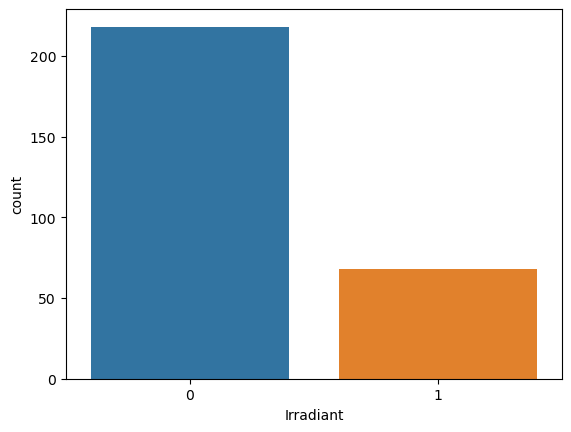

In [40]:
# Check the distributions of 0 and 1 as labelled in Column "Irradiant"
sns.countplot(x="Irradiant", data=all_df)

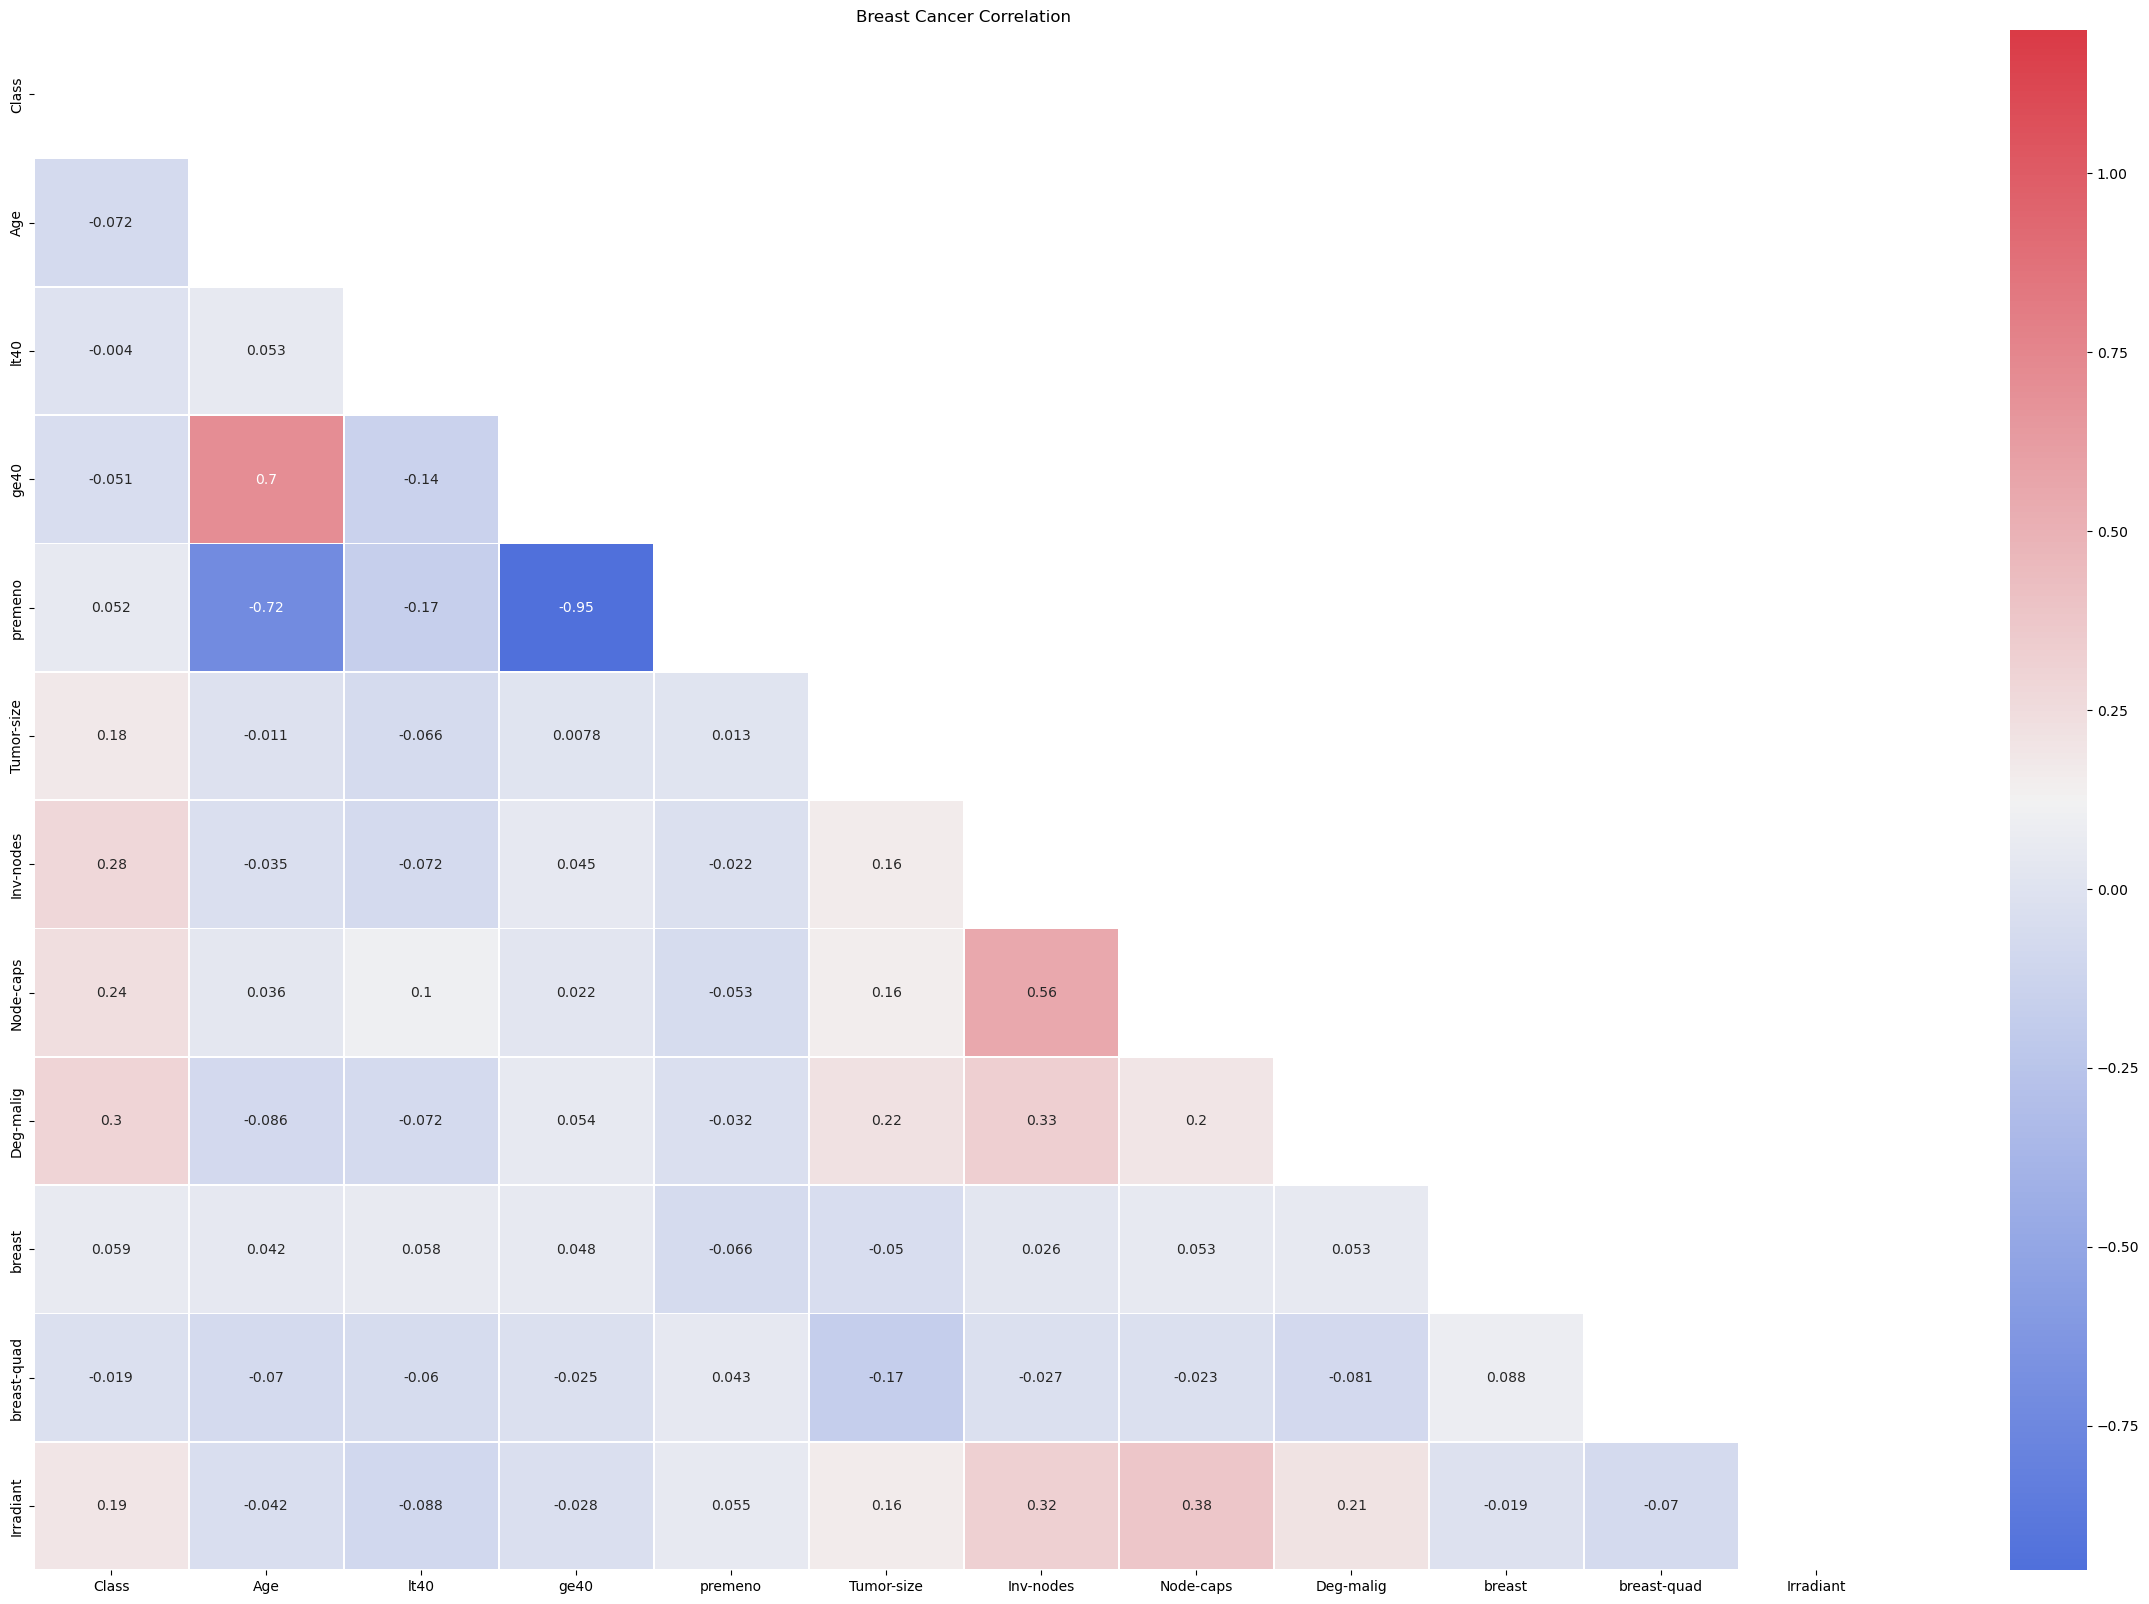

In [41]:
# Analyse the correlation between every two features and result
corrMatt = all_df.corr()
mask = np.zeros_like(corrMatt)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(30, 20))
plt.title('Breast Cancer Correlation')
cmap = sns.diverging_palette(260, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corrMatt, vmax=1.2, square=False, cmap=cmap, mask=mask, ax=ax, annot=True, fmt='.2g', linewidths=0.5);

After analysing the correlation between every two features. We decided to delete breast since it has low relationship with all other features and result. 


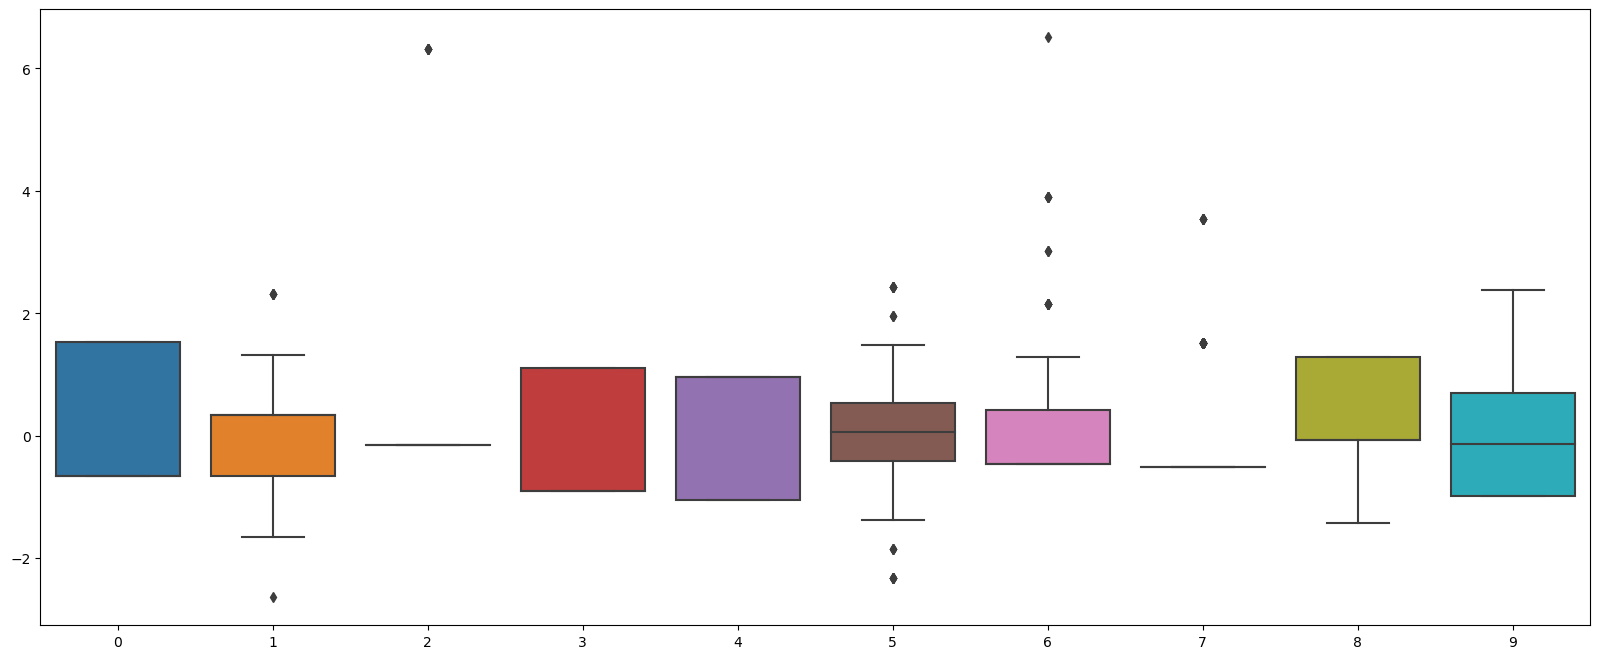

In [42]:
# Normalise the features to use zero mean normalisation
features = X.drop("breast", axis = 1)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features = scaler.fit_transform(features)
fig,ax=plt.subplots(1,figsize=(20,8))
sns.boxplot(data=features,ax=ax) 

After the normalisation. we can see that some features actually have weird distribution. For example, '2' in the above box chart, which is lt40 in the original dataset, has such distribution because about 98% of the original dataset is 0 and the rest is 1. Therefore, the normalisation has changed all the 1s into some value above 6 and this is the drawback of zero mean normalisation when data is very unequally distributed.

In [43]:
x_train, x_test, y_train, y_test = train_test_split(features, all_df['Irradiant'], test_size=0.3, random_state=1, stratify=all_df['Irradiant'])

### 2. Logistic Regression
Use logistic regression to draw the Plot confusion matrix. We found that misdiagnosis rate was __40%__ and the probability of not being diagnosed is __55%__

The 5-fold cross-validation accuracy score for this classifier is 0.78


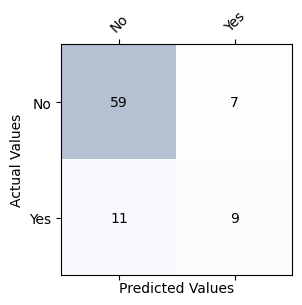

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

clf = LogisticRegression(max_iter = 1000)
cv_error = np.average(cross_val_score(clf, features, target, scoring='accuracy'))
print('The {}-fold cross-validation accuracy score for this classifier is {:.2f}'.format(5, cv_error))

pred = clf.fit(x_train,y_train).predict(x_test)

cm = confusion_matrix(y_test, pred)

# Plot confusion matrix,
fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
         ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center')
classes=["No","Yes"]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Values', )
plt.ylabel('Actual Values');

### 3. SVM

In [45]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold

svm = SVC(kernel="rbf", gamma='auto')

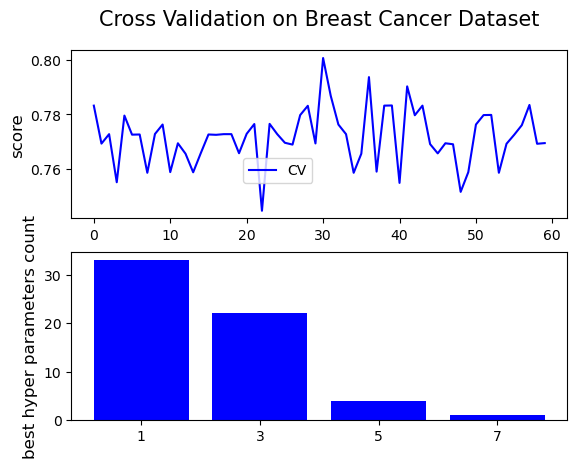

In [46]:
NUM_TRIALS = 60
X = features
y = target

# Set up possible values of parameters to optimize over
p_grid = {"C": [1, 3, 5, 7]}

scores = np.zeros(NUM_TRIALS)
params = []

for i in range(NUM_TRIALS):

    cv = KFold(n_splits=5, shuffle=True, random_state=i)

    clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=cv)
    clf.fit(X,y)
    scores[i] = clf.best_score_
    params.append(clf.best_params_)


best_hyper_params_count = np.zeros(4)
for i in params:
    if params.count(i) >= 1:
        best_hyper_params_count[int((i["C"]-1)/2)] = params.count(i)

# Plot scores on each trial for CV
plt.figure()
plt.subplot(211)
(line,) = plt.plot(scores, color="b")
plt.ylabel("score", fontsize="12")
plt.legend(
    [line],
    ["CV"],
    bbox_to_anchor=(0, 0.4, 0.5, 0),
)
plt.title(
    "Cross Validation on Breast Cancer Dataset",
    x=0.5,
    y=1.1,
    fontsize="15",
)

plt.subplot(212)

plt.bar(range(len(best_hyper_params_count)), best_hyper_params_count,fc='b', tick_label=[1,3,5,7])
plt.ylabel("best hyper parameters count", fontsize="12")
plt.show()

From the bar chart, we can conclude that __C = 1.0__ is the best hyperparameter.

In [47]:
svm = SVC(C=1.0, kernel="rbf", gamma='auto', degree=3)
cv_error_array = cross_val_score(svm, features, target, scoring='accuracy')
average = np.average(cv_error_array)
print('The {}-fold cross-validation accuracy score for this classifier is {:.2f}'.format(5, average))

The 5-fold cross-validation accuracy score for this classifier is 0.79


Use svc with __C = 1.0__ to draw the Plot confusion matrix. We found that misdiagnosis rate was __50%__ and the probability of not being diagnosed is __75%__

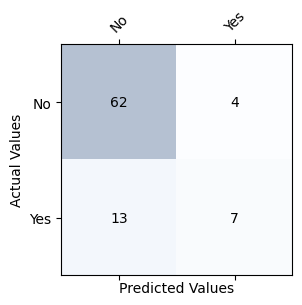

In [48]:
svm = SVC(C=1.0, kernel="rbf", gamma='auto', degree=3)
pred = svm.fit(x_train,y_train).predict(x_test)
cm = confusion_matrix(y_test, pred)
# Plot confusion matrix,
fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
         ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center')
classes=["No","Yes"]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Values', )
plt.ylabel('Actual Values');

### 4. Decision Tree

In [49]:
from sklearn import tree
tree_clf = tree.DecisionTreeClassifier()

In [50]:
NUM_TRIALS = 150
X = features
y = target

# Set up possible values of parameters to optimize over
p_grid = {'max_depth': [3, 5, 7, 9, 11], 'min_samples_split':[5, 10, 15]}

scores = np.zeros(NUM_TRIALS)
params = []

for i in range(NUM_TRIALS):

    cv = KFold(n_splits=5, shuffle=True, random_state=i)

    clf = GridSearchCV(estimator=tree_clf, param_grid=p_grid, cv=cv)
    clf.fit(X,y)
    scores[i] = clf.best_score_
    params.append(clf.best_params_)

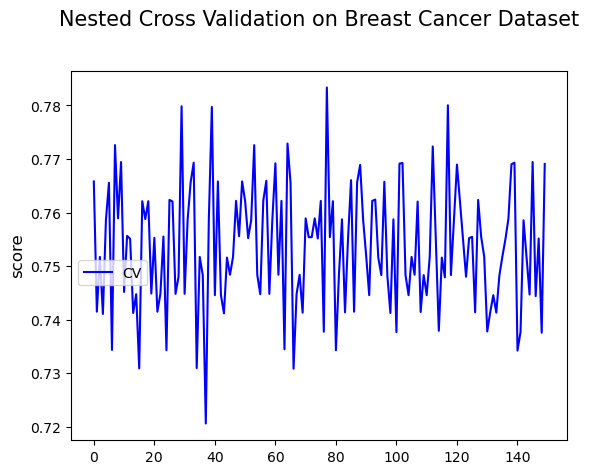

In [51]:
best_hyper_params_count = [[0 for i in range(5)] for j in range(3)]
for i in params:
    best_hyper_params_count[int(i['min_samples_split']/5-1)][int((i['max_depth']-3)/2)] = params.count(i)

# Plot scores on each trial for nested and non-nested CV
plt.figure()
(line,) = plt.plot(scores, color="b")
plt.ylabel("score", fontsize="12")
plt.legend(
    [line],
    ["CV"],
    bbox_to_anchor=(0, 0.4, 0.5, 0),
)
plt.title(
    "Nested Cross Validation on Breast Cancer Dataset",
    x=0.5,
    y=1.1,
    fontsize="15",
)

plt.show()


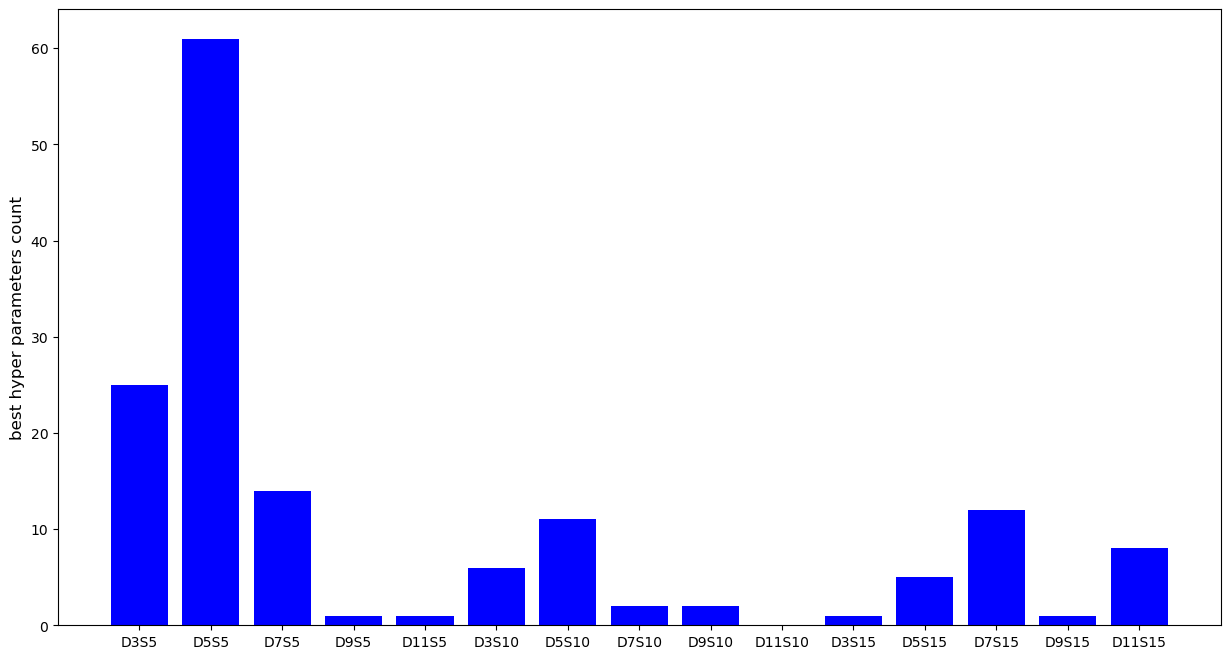

In [52]:
plt.figure(figsize = (15,8))

whole_list = best_hyper_params_count[0] + best_hyper_params_count[1] + best_hyper_params_count[2]

lang = []

for j in range(5,20,5):
    for i in range(3,13,2):
        lang.append('D' + str(i) + 'S' + str(j))       

plt.bar(range(len(whole_list)), whole_list, fc='b', tick_label=lang)

plt.ylabel("best hyper parameters count", fontsize="12")

plt.show()

From the cross validation above, we can see that __max_depth = 5__ and __min_samples_split = 5__ give the best result.

In [53]:
tree_clf = tree.DecisionTreeClassifier(max_depth = 5, min_samples_split = 5)

cv_error = np.average(cross_val_score(tree_clf, features, target))

print('The {}-fold cross-validation accuracy score for this classifier is {:.2f}'.format(5, cv_error))

The 5-fold cross-validation accuracy score for this classifier is 0.74


Use decision tree with __max_depth = 5__ and __min_samples_split = 5__ to draw the Plot confusion matrix. We found that misdiagnosis rate was __64.7%__ and the probability of not being diagnosed is __70%__

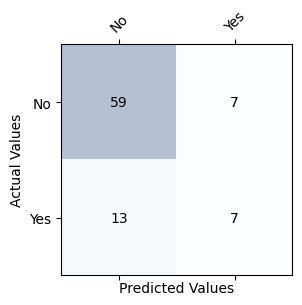

In [54]:
pred = tree_clf.fit(x_train,y_train).predict(x_test)
cm = confusion_matrix(y_test, pred)
# Plot confusion matrix,
fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
         ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center')
classes=["No","Yes"]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Values', )
plt.ylabel('Actual Values');

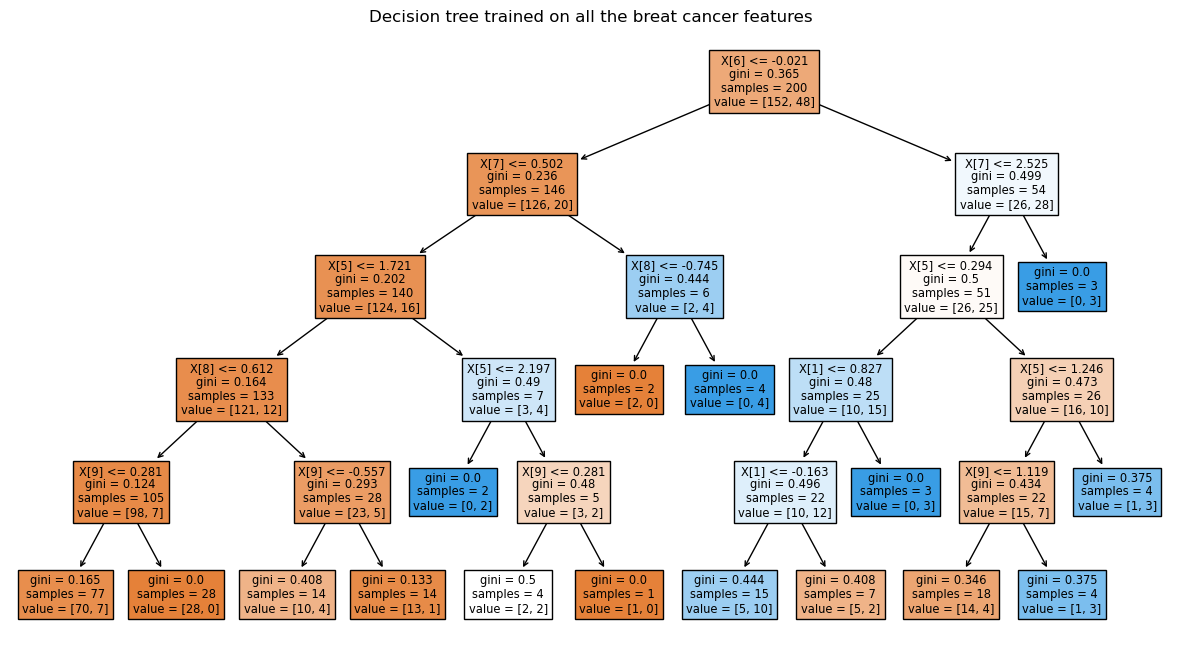

In [59]:
from sklearn.tree import plot_tree

plt.figure(figsize = (15,8))
plot_tree(tree_clf.fit(x_train,y_train), filled=True)
plt.title("Decision tree trained on all the breat cancer features")
plt.show()

### 5. ANN

In [63]:
from tensorflow import keras
from tensorflow.keras.optimizers import SGD

x_train, x_test, y_train, y_test = train_test_split(features, all_df['Irradiant'], test_size=0.3, random_state=1, stratify=all_df['Irradiant'])

# initiate all the models separately with one and two layers, and with learning rate of 0.1, 0.01, 0.001
model_one_layer_1=keras.models.Sequential()
model_one_layer_1.add(keras.layers.Dense(32, input_dim=10,activation="relu"))
model_one_layer_1.add(keras.layers.Dense(1, activation='sigmoid'))

model_one_layer_2=keras.models.Sequential()
model_one_layer_2.add(keras.layers.Dense(32, input_dim=10,activation="relu"))
model_one_layer_2.add(keras.layers.Dense(1, activation='sigmoid'))

model_one_layer_3=keras.models.Sequential()
model_one_layer_3.add(keras.layers.Dense(32, input_dim=10,activation="relu"))
model_one_layer_3.add(keras.layers.Dense(1, activation='sigmoid'))

model_one_layer_1.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=0.1), metrics=['accuracy'])
model_one_layer_2.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=0.01), metrics=['accuracy'])
model_one_layer_3.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=0.001), metrics=['accuracy'])

model_two_layer_1=keras.models.Sequential()
model_two_layer_1.add(keras.layers.Dense(32, input_dim=10,activation="relu"))
model_two_layer_1.add(keras.layers.Dense(16 ,activation="relu"))
model_two_layer_1.add(keras.layers.Dense(1, activation='sigmoid'))

model_two_layer_2=keras.models.Sequential()
model_two_layer_2.add(keras.layers.Dense(32, input_dim=10,activation="relu"))
model_two_layer_2.add(keras.layers.Dense(16 ,activation="relu"))
model_two_layer_2.add(keras.layers.Dense(1, activation='sigmoid'))

model_two_layer_3=keras.models.Sequential()
model_two_layer_3.add(keras.layers.Dense(32, input_dim=10,activation="relu"))
model_two_layer_3.add(keras.layers.Dense(16 ,activation="relu"))
model_two_layer_3.add(keras.layers.Dense(1, activation='sigmoid'))

model_two_layer_1.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=0.1), metrics=['accuracy'])
model_two_layer_2.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=0.01), metrics=['accuracy'])
model_two_layer_3.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=0.001), metrics=['accuracy'])

In [80]:
from sklearn.model_selection import KFold
import os

# root file for logging the learning process and can be visualised later in
# tensorboard
def train_ann(features, target, model, name):
    root_logdir = os.path.join(os.curdir, "my_logs")
    def get_run_logdir():
         import time
         run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
         return os.path.join(root_logdir, run_id)

    run_logdir = get_run_logdir()
    kf = KFold(n_splits=5)
    k=1
    
    all_score = []

    for train_index, test_index in kf.split(features):
        print("fold",k)
        # Split the data
        X_train, X_test = np.array(features)[train_index], np.array(features)[test_index]
        y_train, y_test = np.array(target)[train_index], np.array(target)[test_index]
        # tensorboard for visualising the training process later
        tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
        early_stopping = keras.callbacks.EarlyStopping(monitor='acc', patience=1)
        # training and validation
        model.fit(np.array(X_train), np.array(y_train), epochs=30, validation_data=(np.array(X_test), np.array(y_test)),callbacks=[tensorboard_cb, early_stopping])

        #save the model of each fold
        model.save(os.path.join('fold_{}_{}.hdf5'.format(k, name)))

        # evaluate the accuracy of each fold
        scores = model.evaluate(np.array(X_test), np.array(y_test), verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        
        k = k+1
    
        all_score.append(scores[1]*100)
    
    return all_score
        
six_ann_scores = []        

six_ann_scores.append(train_ann(features=features, target=target, model=model_one_layer_1, name="model_one_layer_1"))
six_ann_scores.append(train_ann(features=features, target=target, model=model_one_layer_2, name="model_one_layer_2"))
six_ann_scores.append(train_ann(features=features, target=target, model=model_one_layer_3, name="model_one_layer_3"))
six_ann_scores.append(train_ann(features=features, target=target, model=model_two_layer_1, name="model_two_layer_1"))
six_ann_scores.append(train_ann(features=features, target=target, model=model_two_layer_2, name="model_two_layer_2"))
six_ann_scores.append(train_ann(features=features, target=target, model=model_two_layer_3, name="model_two_layer_3"))

print(six_ann_scores)


fold 1
Train on 228 samples, validate on 58 samples
Epoch 1/30
228/228 [==============================] - 0s 95us/sample - loss: 0.2502 - acc: 0.8991 - val_loss: 0.2312 - val_acc: 0.9310
Epoch 2/30
228/228 [==============================] - 0s 57us/sample - loss: 0.2547 - acc: 0.9167 - val_loss: 0.2209 - val_acc: 0.9310
Epoch 3/30
228/228 [==============================] - 0s 57us/sample - loss: 0.2366 - acc: 0.9254 - val_loss: 0.2077 - val_acc: 0.9483
Epoch 4/30
228/228 [==============================] - 0s 44us/sample - loss: 0.2449 - acc: 0.9079 - val_loss: 0.2257 - val_acc: 0.9310
acc: 93.10%
fold 2
Train on 229 samples, validate on 57 samples
Epoch 1/30
229/229 [==============================] - 0s 75us/sample - loss: 0.2470 - acc: 0.8996 - val_loss: 0.1731 - val_acc: 0.9474
Epoch 2/30
229/229 [==============================] - 0s 57us/sample - loss: 0.2381 - acc: 0.9127 - val_loss: 0.2243 - val_acc: 0.9298
Epoch 3/30
229/229 [==============================] - 0s 44us/sample - los

229/229 [==============================] - 0s 48us/sample - loss: 0.1004 - acc: 0.9694 - val_loss: 0.2432 - val_acc: 0.8772
Epoch 3/30
229/229 [==============================] - 0s 57us/sample - loss: 0.0937 - acc: 0.9651 - val_loss: 0.1843 - val_acc: 0.9123
acc: 91.23%
fold 1
Train on 228 samples, validate on 58 samples
Epoch 1/30
228/228 [==============================] - 0s 66us/sample - loss: 0.4001 - acc: 0.8377 - val_loss: 0.3088 - val_acc: 0.8793
Epoch 2/30
228/228 [==============================] - 0s 39us/sample - loss: 0.3998 - acc: 0.8377 - val_loss: 0.3094 - val_acc: 0.8793
acc: 87.93%
fold 2
Train on 229 samples, validate on 57 samples
Epoch 1/30
229/229 [==============================] - 0s 57us/sample - loss: 0.3763 - acc: 0.8384 - val_loss: 0.4031 - val_acc: 0.8772
Epoch 2/30
229/229 [==============================] - 0s 48us/sample - loss: 0.3752 - acc: 0.8384 - val_loss: 0.4042 - val_acc: 0.8772
acc: 87.72%
fold 3
Train on 229 samples, validate on 57 samples
Epoch 1/3

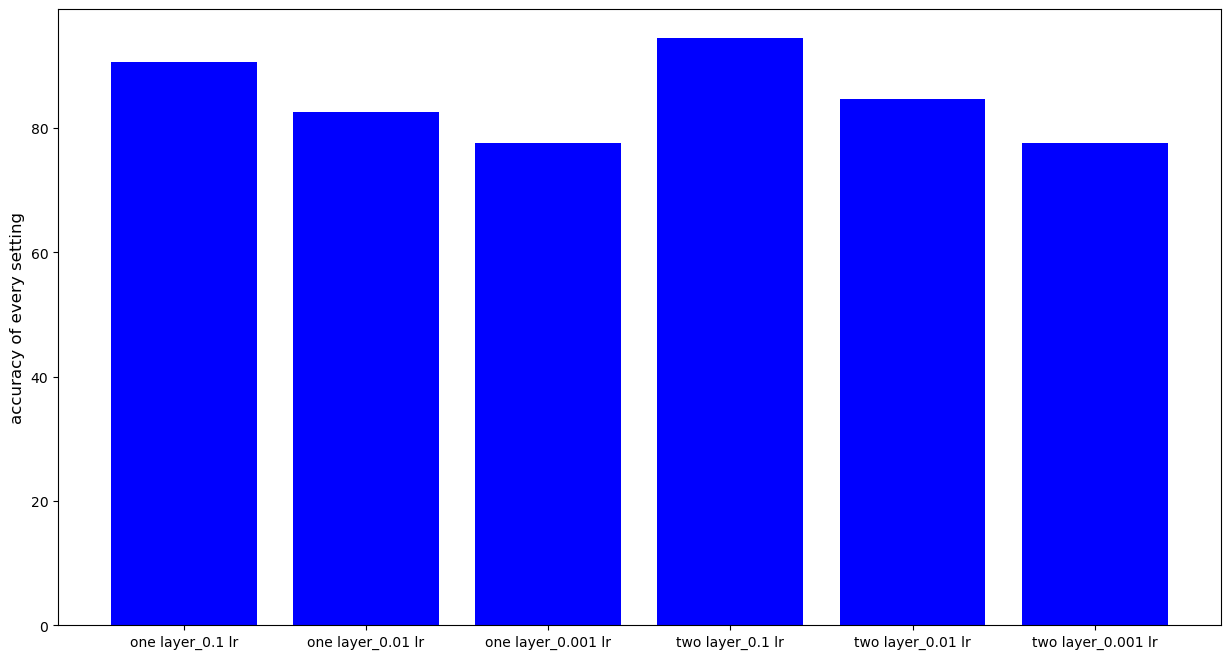

86/86 - 0s - loss: 0.1064 - acc: 0.9419
Restored model best performance, accuracy: 94.19%


In [84]:
plt.figure(figsize = (15,8))

whole_list = []

lang = ['one layer_0.1 lr', 'one layer_0.01 lr', 'one layer_0.001 lr', 'two layer_0.1 lr', 'two layer_0.01 lr', 'two layer_0.001 lr']

for elem in six_ann_scores:
    whole_list.append(np.mean(elem))   

plt.bar(range(len(whole_list)), whole_list, fc='b', tick_label=lang)

plt.ylabel("accuracy of every setting", fontsize="12")

plt.show()

x_train, x_test, y_train, y_test = train_test_split(features, all_df['Irradiant'], test_size=0.3, random_state=1, stratify=all_df['Irradiant'])

model_two_layer_1.load_weights('fold_1_model_two_layer_1.hdf5')

y_pred=model_two_layer_1.predict(np.array(x_test))

loss, acc = model_two_layer_1.evaluate(np.array(x_test), np.array(y_test), verbose=2)
print("Restored model best performance, accuracy: {:5.2f}%".format(100 * acc))


From the cross validation above, we can see that the two layer neural network with 0.1 learning rate gave the best result.